In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

## Load canine data

In [2]:
mpc = pd.read_json("s3://savsnet-agile-upload/mpc_08-08-2022.json.gz", 
                   storage_options={"profile":"savsnet-agile", 
                                    "client_kwargs": {"endpoint_url": "https://fhm-chicas-storage.lancs.ac.uk"}}
                  )
mpc_agg = mpc.groupby(["species", "location", "date"]).agg("sum")
dogs = mpc_agg.loc["dog"].groupby(level=1).sum()["2016-02-28":"2020-02-28"]

## Calculate empirical logit prevalence

This section calculates the empirical prevalence of gastroenteric MPCs, and then uses the logit transform.  Finally, we create a "debiased" version of the logit prevalence by subtracting the mean so that we can apply the Fourier decomposition.

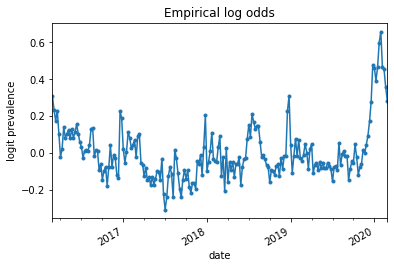

In [4]:
# Debias the empirical prevalence
dogs["prev"] = dogs["gastroenteric"] / dogs["total_count"]
dogs["logit_prev"] = np.log(dogs["prev"]/(1-dogs["prev"]))
dogs["logit_prev_debiased"] = dogs["logit_prev"] - dogs["logit_prev"].mean()

# Plot the debiased empirical log odds over time.
dogs["logit_prev_debiased"].plot(marker=".")
plt.ylabel("logit prevalence")
plt.title("Empirical log odds")
plt.gcf().autofmt_xdate()

## Now we perform a Fourier transform so we can study the important harmonics 

The Fourier decomposition is designed to pick out the first $k$ "important" frequencies in the timeseries, so that we can take them forward into the model.  Note that the time scaling below is likely to be wrong -- we need to think this through a bit more carefully.

/home/jewellcp/Insync/jewellcp@lancaster.ac.uk/OneDrive Biz/Grants/AGILE/harmonic_detector/.venv/lib/python3.8/site-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jewellcp/Insync/jewellcp@lancaster.ac.uk/OneDrive Biz/Grants/AGILE/harmonic_detector/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 20.0)

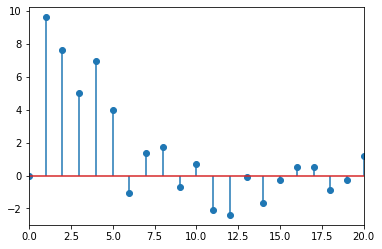

In [5]:
# Fourier transform calculates coefficients for each frequency in units of periods per length of the timeseries
coefs = np.fft.fft(dogs["logit_prev_debiased"])[:dogs.shape[0]//2]

# Utility to calculate frequencies for the x-axis below
freqs = np.fft.fftfreq(dogs.shape[0], 1/dogs.shape[0])[:dogs.shape[0]//2]

# Plot the transform (or at least the first 20 components)
plt.stem(freqs, coefs)
plt.xlim((0, 20))

Here I make a subjective judgement as to which frequencies are dominating, choosing to truncate the Fourier series beyond the 5th harmonic.  
In principle, it would be better to do this by creating a null distribution of the Fourier series by repeatedly calculating it on a permuted timeseries.

## The model

Let $y_t$ be the number of MPCs observed
at time $t=1,\dots,T$, with $n_t$ being the total number of consults seen at that time.  We model
$$
y_t \sim \mbox{Binomial}(n_t, p_t)
$$
letting
$$
\mbox{logit}(p_t) = \alpha + \beta (t-\bar{t}) + h_t^T \gamma + u_t.
$$

Here, $\alpha$ is the overall mean prevalence, and $\beta$ captures a longitudinal linear trend.  $H$, the harmonic series matrix and for which $h_t$ represent a row, is a $T \times 10$ matrix with elements
$$
h_{tk} = \begin{cases} \cos(\frac{2\pi kt}{365}) & \mbox{for } k = 1,\dots,5 \\ \sin(\frac{2\pi kt}{365}) & \mbox{for } k = 6,\dots,10 \end{cases}.
$$

Finally, $u$ is a vector of correlated random effects, distributed according to a Gaussian Process
$$
u \sim \mbox{MVN}(0, \Sigma^2)
$$
with a Matern32 correlation structure with uncorrelated additional noise.  Thus
$$
\Sigma^2_{st} = \begin{cases}
    \sigma^2 + \tau^2 & \mbox{if } s=t \\
    \sigma^2 \left( 1 + \frac{\sqrt{3(t - s)^2}}{\phi} \right) \exp \left(\frac{-\sqrt{3(t-s)^2}}{\phi}\right) & \mbox{otherwise} \\
    \end{cases}
$$

In the implementation, we first construct the $H$ matrix, before constructing the model using a TensorFlow Probability `JointDistributionCoroutineAutoBatched`.  The same model would be more easily implemented using PyMC3, but I didn't have it to hand when I wr

In [6]:
def build_harmonic_matrix(t, num_harmonics=5, period=365):
    """Build up a matrix of dummy harmonic variables
    
    :param t: a vector of times of length `T`
    :param hum_harmonics: the required number of harmonics
    :param period: the length of one period, in the same units as `t`
    :returns: a `[T, 2*num_harmonics]` matrix
    """
    harmonics = 2*np.pi/period * np.arange(1.0, num_harmonics+1.0)
    t_harmonic = t[:, np.newaxis] * harmonics[np.newaxis, :]
    
    # Concatenate cos and sin functions by column
    harmonic_matrix = np.concatenate([tf.math.cos(t_harmonic), 
                                      tf.math.sin(t_harmonic)], axis=-1)
    
    return harmonic_matrix


def build_model(t, n, design_matrix, dtype=tf.float32):
    """Builds and returns a TFP JointDistributionCoroutineAutoBatched object
       representing the harmonic regression with correlated residuals.
       
       :param t: timepoints
       :param n: total number of trials per timepoint
       :design_matrix: a TxP matrix where `T = t.shape[0]` and `P` is the number of 
                         covariates.
       :returns: A `tfd.JointDistributionCoroutineAutoBatched` object.
    """
    
    t = tf.convert_to_tensor(t, dtype=dtype)
    n = tf.convert_to_tensor(n, dtype=dtype)
    design_matrix = tf.convert_to_tensor(design_matrix, dtype=dtype)
    
    num_covariates = design_matrix.shape[-1]
    
    def model_fn():
        coefficients = yield tfd.Independent(
            tfd.Normal(loc=tf.zeros(num_covariates), 
                                    scale=10.0, 
                                    name="coefficients"),
            reinterpreted_batch_ndims=1,
            name="coefficients")
        
        # Define the GP
        length_scale = yield tfd.HalfNormal(scale=10.0, name="length_scale")
        gp_variance = yield tfd.HalfNormal(scale=1.0, name="gp_variance")
        observation_noise_variance = yield tfd.HalfNormal(scale=10.0, 
                                                          name="observation_noise_variance")
        
        kernel = tfp.math.psd_kernels.MaternThreeHalves(amplitude=gp_variance, 
                                                        length_scale=length_scale)
        gp = yield tfd.GaussianProcess(kernel=kernel,
                                      index_points=t[:, tf.newaxis],
                                      observation_noise_variance=observation_noise_variance,
                                      name="gaussian_process")
        
        # Assemble mean function
        eta = tf.linalg.matvec(design_matrix, coefficients) + gp

        # Observation model
        y = yield tfd.Independent(
            tfd.Binomial(n, logits=eta, name="y"),
            reinterpreted_batch_ndims=1,
            name="y")

    return tfd.JointDistributionCoroutineAutoBatched(model_fn)

In [7]:
# Assemble design matrix and construct the model
times = np.arange(dogs.shape[0])*7.0

design_matrix = np.concatenate(
    [
        np.ones((dogs.shape[0],1)),  # Ones vector for intercept
        times[:, np.newaxis] - np.mean(times),  # Centred time
        build_harmonic_matrix(times, num_harmonics=5), # Harmonic matrix
    ],
    axis=-1
)

model = build_model(times, dogs["total_count"], design_matrix)

2022-09-08 13:37:49.105100: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-08 13:37:49.105221: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: diamond
2022-09-08 13:37:49.105229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: diamond
2022-09-08 13:37:49.105568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-08 13:37:49.105617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-08 13:37:49.105623: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-08 13:37:49.107447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

## Having constructed the model, we "pin" it

In TensorFlow Probability terms, "pinning" a model means conditioning it on an observed random variable, in this case $y$ our 
MPC cases.

In [8]:
conditioned_model = model.experimental_pin(y=dogs["gastroenteric"])

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


## Inference

Here we construct an adaptive NUTS algorithm to draw samples from our joint posterior distribution.  

We first simulate from the _prior_ of the "unpinned" variables to get a data structure we can then set 
MCMC starting values for.

In [9]:
xsim = conditioned_model.sample_unpinned()  # This line just grabs us a data structure representing unpinned vars.

# Initial MCMC chain state - we grab the _class_ of the `xsim` object and
# reconstruct it with sane values to start off our MCMC below.
initial_mcmc_state = xsim.__class__(coefficients=tf.zeros((1, design_matrix.shape[-1])),
                                    length_scale=tf.constant([0.1]),
                                    gp_variance=tf.constant([0.1]),
                                    observation_noise_variance=tf.constant([0.1]),
                                    gaussian_process=tf.zeros((1, dogs.shape[0]))
                                    )

# Check that the joint log posterior is finite before building the MCMC
assert tf.math.is_finite(conditioned_model.log_prob(initial_mcmc_state))

## Run the MCMC

The MCMC is run using the convenience function `tfp.experimental.mcmc.windowed_adaptive_nuts` which builds and runs 
a NUTS sampler using windowed adaptation of the mass matrix and step size à la STAN.

In [ ]:
@tf.function(jit_compile=True)
def sample():
    return tfp.experimental.mcmc.windowed_adaptive_nuts(2500, 
                                                       conditioned_model,
                                                       num_adaptation_steps=1000,
                                                       n_chains=1,
                                                       current_state=initial_mcmc_state,
                                                      )

start = time.perf_counter()
samples, results = sample()
end = time.perf_counter()
print("Elapsed time:", end-start, "seconds")

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-09-08 13:38:22.061474: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x55a2f9273c60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-08 13:38:22.061498: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-09-08 13:38:22.411589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-09-08 13:38:22.633379: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2022-09-08 13:38:39.515091: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
fig, ax = plt.subplots(len(samples), 2, figsize=(8, 15))
for i, (k, v) in enumerate(samples._asdict().items()):
    ax[i][0].plot(v[:,0])
    ax[i][0].set_ylabel(k)
    sns.kdeplot(data=v[:, 0], ax=ax[i][1], legend=False)

exceed prob size: (209,)


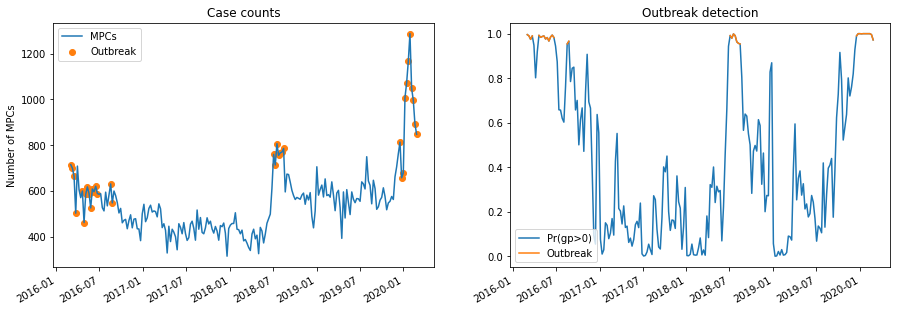

In [64]:
def mask_posterior_exceedance(posterior_gp, threshold=0.0, prob=0.95):
    exceed_prob = (posterior_gp > threshold).mean(axis=0)
    print("exceed prob size:", exceed_prob.shape)
    not_exceed_flag = exceed_prob < prob
    exceed_prob[not_exceed_flag] = np.nan
    return exceed_prob
    
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
exceedance_mask = mask_posterior_exceedance(samples.gaussian_process[:, 0].numpy())
ax[0].plot(dogs["gastroenteric"], label="MPCs")
ax[0].scatter(dogs.index[~np.isnan(exceedance_mask)], 
              dogs["gastroenteric"][~np.isnan(exceedance_mask)],
              color="C1",
              label="Outbreak")
ax[0].set_ylabel("Number of MPCs")
ax[0].set_title("Case counts")
ax[0].legend()
ax[1].plot(dogs.index, 
           tf.reduce_mean(tf.cast(samples.gaussian_process>0, 
                                  samples.gaussian_process.dtype), axis=0)[0],
           label="Pr(gp>0)")
ax[1].plot(dogs.index, exceedance_mask, label="Outbreak")
ax[1].set_title("Outbreak detection")
ax[1].legend()
plt.gcf().autofmt_xdate()

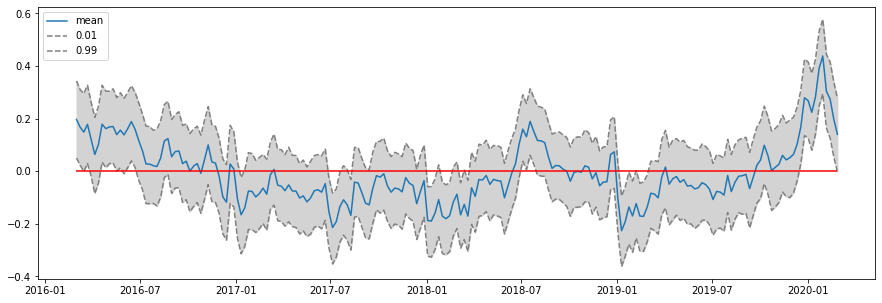

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(dogs.index, samples.gaussian_process[:,0].numpy().mean(axis=0), label="mean")
qtiles = np.quantile(samples.gaussian_process[:,0].numpy(), q=(0.025, 0.975), axis=0)
ax.plot(dogs.index, qtiles[0], color="grey", linestyle="--", label="0.01")
ax.plot(dogs.index, qtiles[1], color="grey", linestyle="--", label="0.99")
ax.fill_between(dogs.index, qtiles[0], qtiles[1], color="lightgrey")
ax.hlines(0, xmin=dogs.index.min(), xmax=dogs.index.max(), color="red")
ax.legend()